In [162]:
import numpy as np
from matplotlib import pyplot as plt

# Es 1

In [163]:
from sklearn.datasets import fetch_olivetti_faces
olivetti = fetch_olivetti_faces()
imgs = olivetti.images
labels = olivetti.target
x = imgs.reshape((400, 4096))
x.shape

(400, 4096)

(400, 4096)

## Point 1

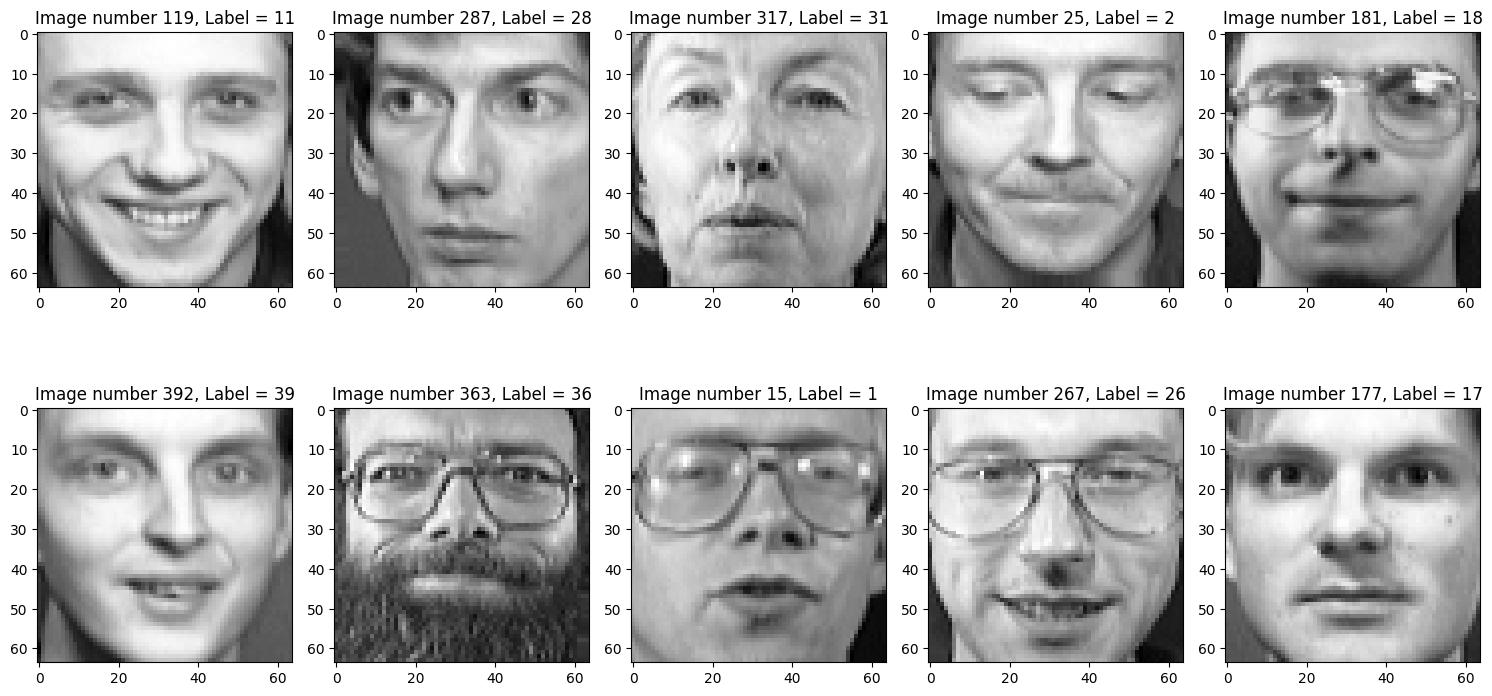

In [ ]:
rand = np.random.choice(np.array(range(len(x))), 10, replace=False)
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 8), squeeze=False)
plt.gray()
axes = axes.reshape(-1)
for i, n in enumerate(rand):
    axes[i].imshow(x[n].reshape((64, 64)))
    axes[i].set_title(f"Image number {n}, Label = {labels[n]}")
plt.tight_layout()

## Point 2

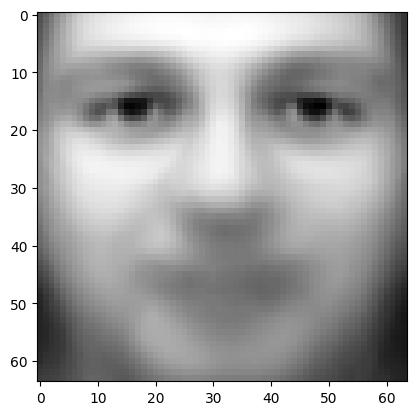

In [ ]:
avg_img = np.zeros((64, 64))
for img in x: avg_img += img.reshape((64, 64))
avg_img /= len(x)
plt.imshow(avg_img);

## Point 3

In [ ]:
x -= x.mean(axis=1)[:, None]
u, s, vt = np.linalg.svd(x, full_matrices=True)
u_, s_, vt_ = np.linalg.svd(x, full_matrices=False)
print(u.shape, s.shape, vt.shape)
print(u_.shape, s_.shape, vt_.shape)
# as expected, the second version of the SVD (economy SVD) is smaller since it only stores the useful information, exploiting the fact that a lot of singular values might be zero

(400, 400) (400,) (4096, 4096)
(400, 400) (400,) (400, 4096)


## Point 4

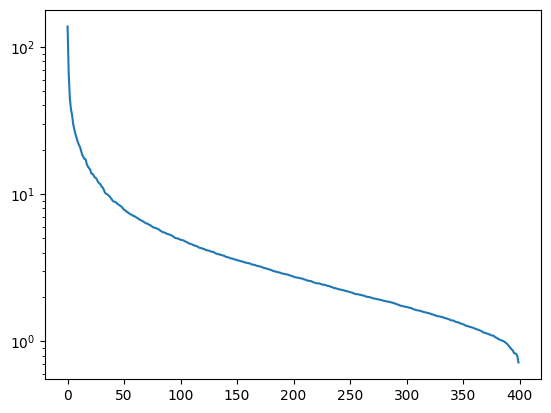

In [167]:
plt.semilogy(s);

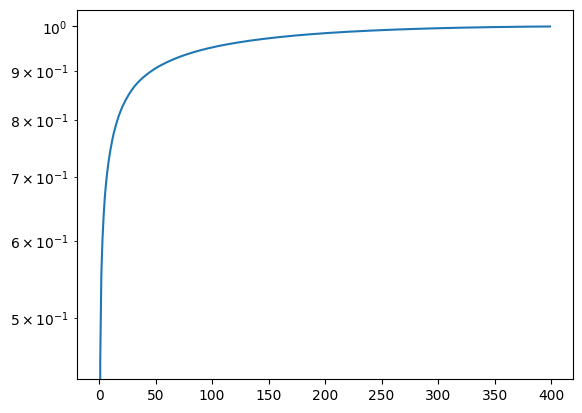

In [168]:
squared = np.square(s)
plt.semilogy([sum(squared[:i]) / sum(squared) for i in range(len(squared))]);

## Point 5

In [169]:
def randomized_SVD(A, k):
  m = A.shape[0]
  n = A.shape[1]

  G = np.random.rand(n, k)
  Y = A @ G
  Q, _ = np.linalg.qr(Y)

  B = np.transpose(Q) @ A
  u, s, vt = np.linalg.svd(B)
  u = Q @ u

  return u, s, vt

## Point 6

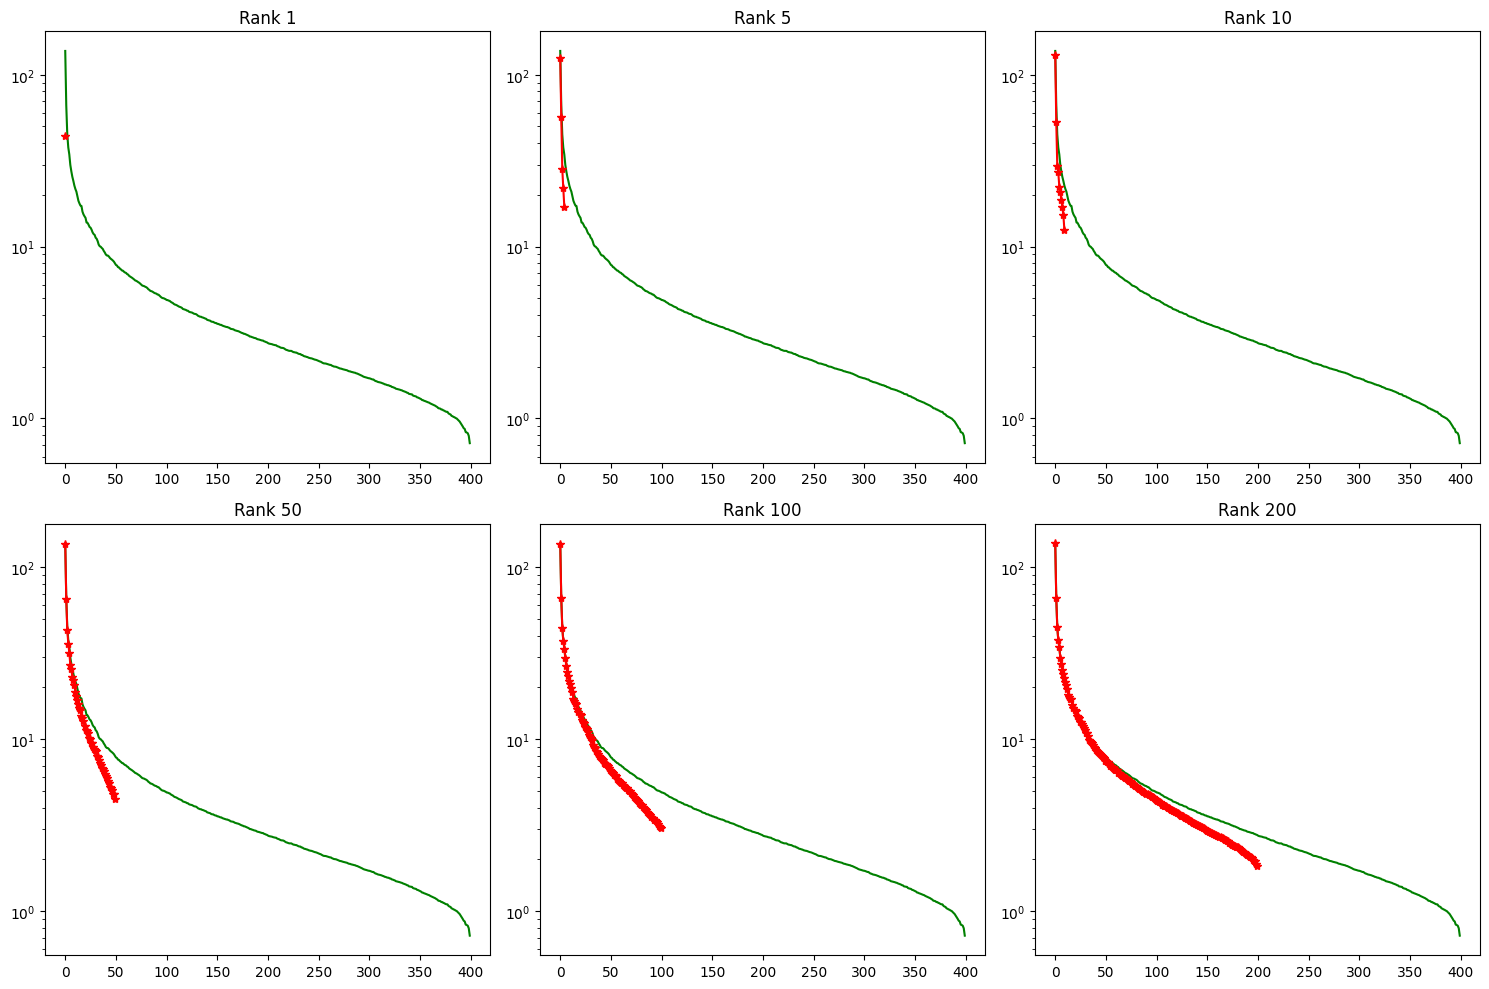

In [170]:
_, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), squeeze=False)
axes = axes.reshape(-1)
ks = [1, 5, 10, 50, 100, 200]
for i, k in enumerate(ks):
    u_rand, s_rand, vt_rand = randomized_SVD(x, k)
    axes[i].semilogy(s, c="g")
    axes[i].semilogy(s_rand, c="r", marker="*")
    axes[i].set_title(f"Rank {k}")
plt.tight_layout()

## Point 7

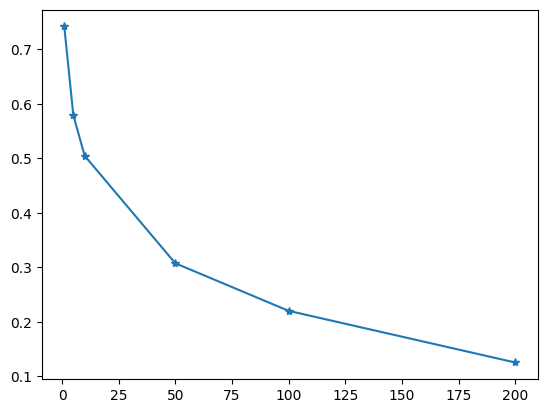

In [171]:
err = list()
v = vt.T
for k in ks:
    phi = x @ v[:, :k] # dimensionality reduction --> from n to k columns
    x_rec = u[:, :k] @ np.diag(s[:k]) @ vt[:k, :]
    err.append(np.linalg.norm(x - x_rec) / np.linalg.norm(x))
plt.plot(ks, err, marker="*");
# As expected, the error is smaller when we make the rank higher. This is because we allow the matrix to have more information about the original data, so the reconstruction is more similar to the original matrix

## Point 8

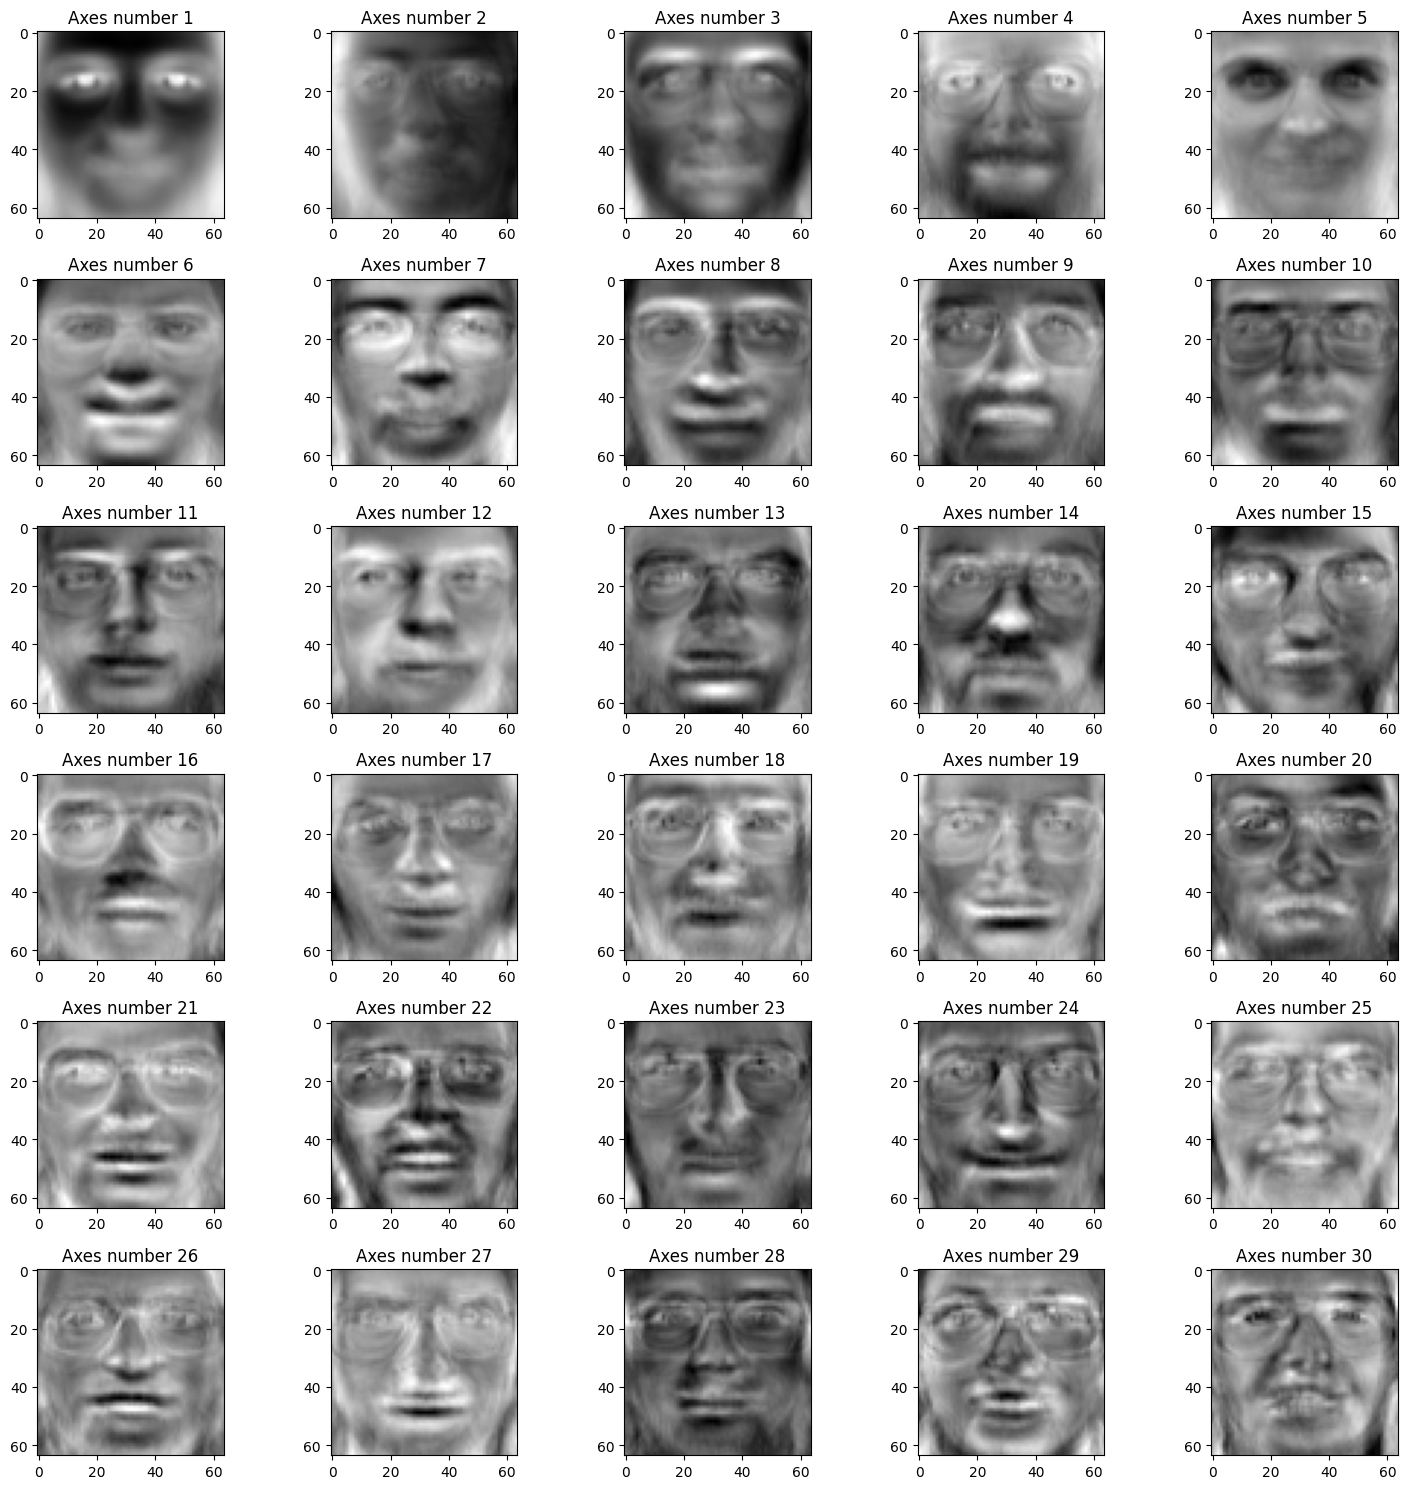

In [172]:
_, axes = plt.subplots(nrows=6, ncols=5, figsize=(15, 15), squeeze=False)
axes = axes.reshape(-1)
for i in range(30):
    axes[i].imshow(v[:, i].reshape((64, 64)))
    axes[i].set_title(f"Axes number {i + 1}")
plt.tight_layout()

## Point 9

In [173]:
comp_0 = list()
comp_39 = list()

for i, img in enumerate(x):
    if labels[i] == 0:
        comp_0.append([img @ v[:, 0], img @ v[:, 1]])
    if labels[i] == 39:
        comp_39.append([img @ v[:, 0], img @ v[:, 1]])

## Point 10

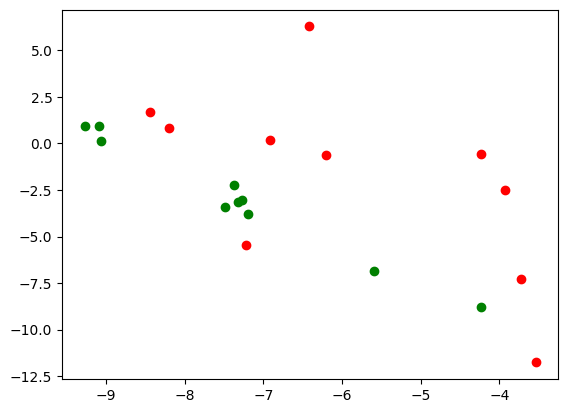

In [174]:
plt.scatter([i[0] for i in comp_0], [i[1] for i in comp_0], c="r")
plt.scatter([i[0] for i in comp_39], [i[1] for i in comp_39], c="g");
# As we can see, there is a slight separation between the 2 labels, but is not significant enough even if we take the 2 most important Components. In order to have a better separation of the data points, we might have to add more Principal Components.

# Es 2

## Point 1

In [175]:
def loss_ridge(x, y, w, lam = 1):
    err = np.sqrt(np.sum(np.square((x @ w) - y)))
    reg = (lam / len(x)) * np.sum(np.square(w))
    return err + reg

## Point 2

In [176]:
def ridge_reg(x, y, lam = 1):
    u, s, vt = np.linalg.svd(x)
    s_mat = np.zeros(x.shape)
    for i, val in enumerate(s):
        s_mat[i][i] = val / (np.square(val) + lam)
    return vt.T @ s_mat.T @ u.T @ y

## Point 3

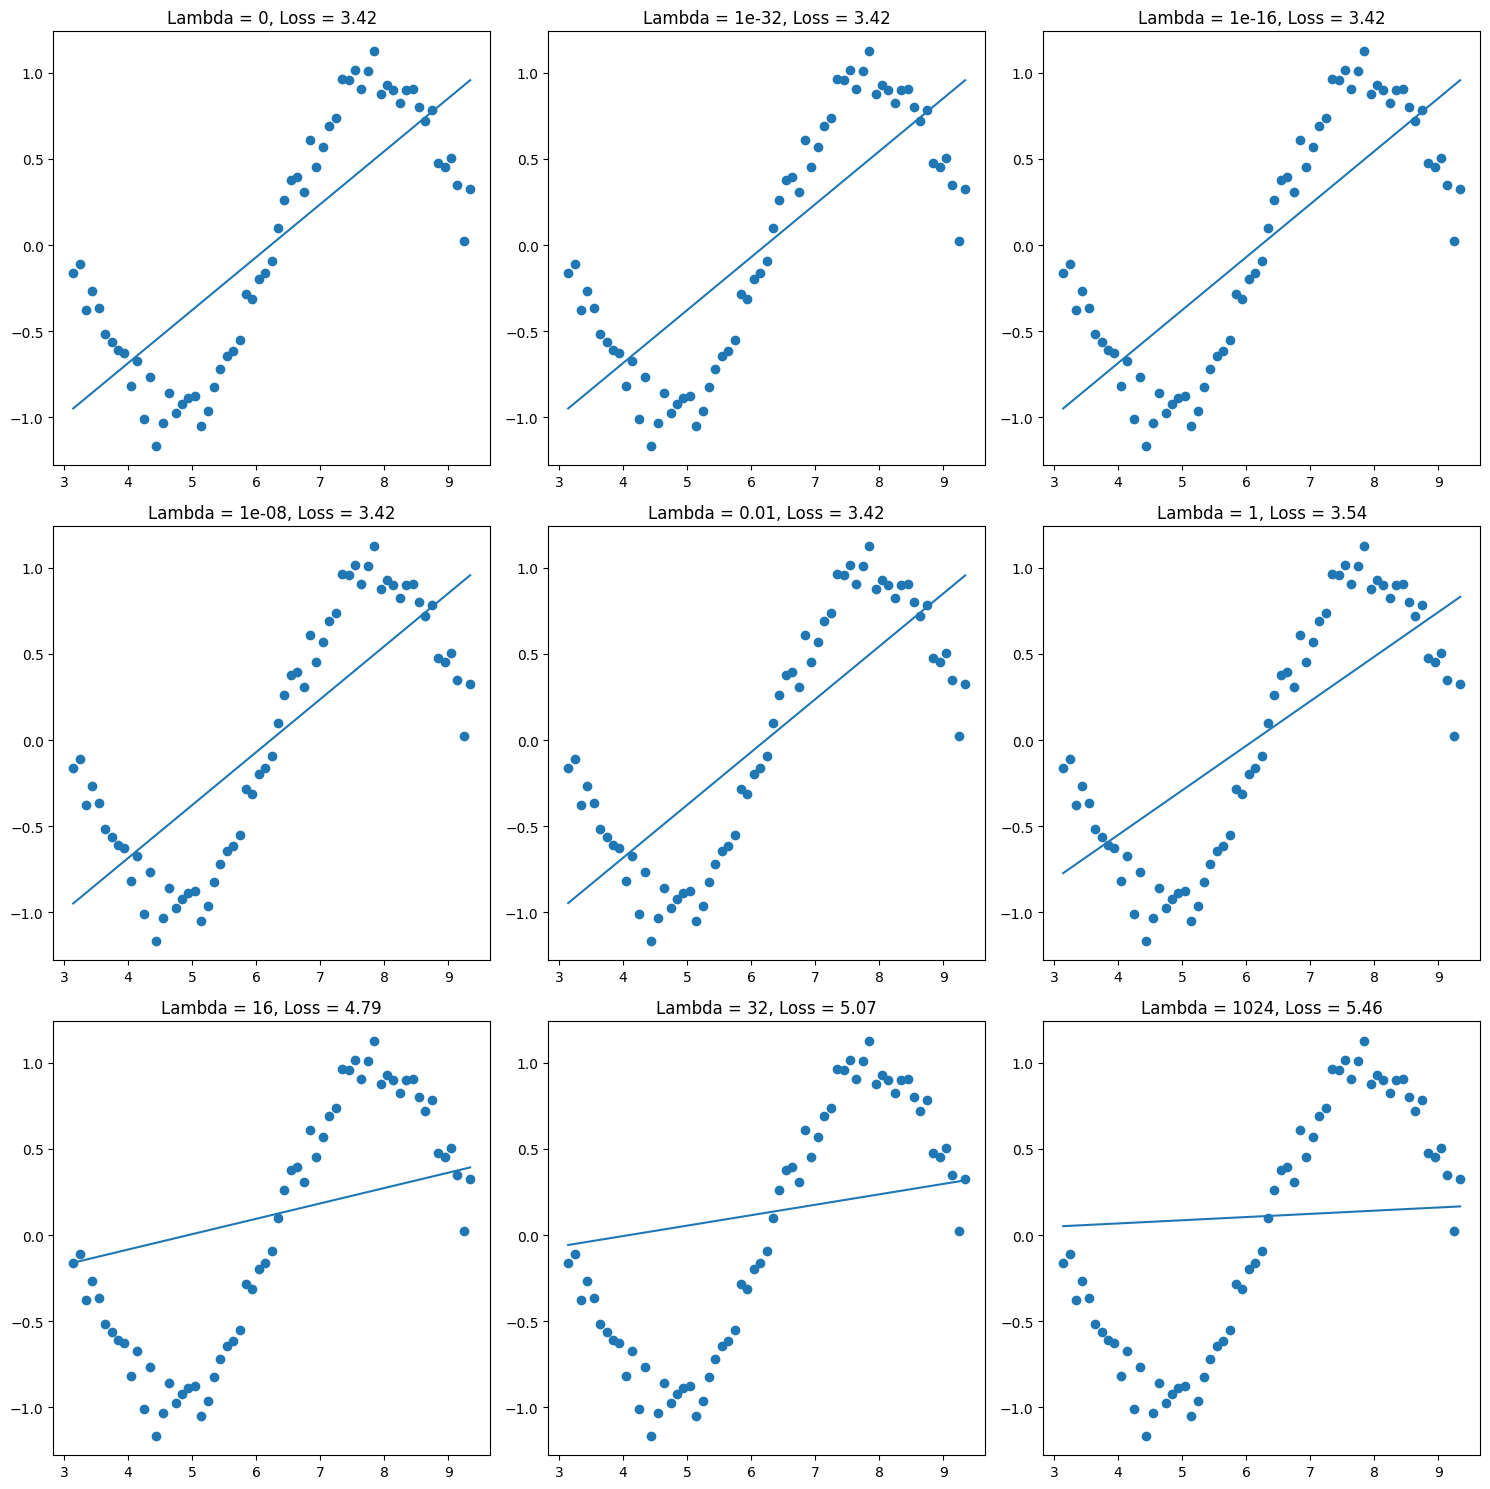

In [177]:
np.random.seed(55)
x = np.arange(np.pi, 3 * np.pi, 0.1)
y = np.sin(x) + np.random.normal(0, 0.1, len(x))
lams = [0, 1e-32, 1e-16, 1e-8, 1e-2, 1, 16, 32, 1024]
_, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), squeeze=False)
axes = axes.reshape(-1)

x = np.array([x, np.ones(x.shape)]).T

for j, lam in enumerate(lams):
    w = ridge_reg(x, y, lam)
    axes[j].scatter(x[:, 0], y)
    axes[j].set_title(f"Lambda = {lam}, Loss = {np.round(loss_ridge(x, y, w, lam), 2)}")
    axes[j].plot([i[0] for i in x], [i @ w for i in x])
plt.tight_layout()
# As expected with higher lambda we have enormous underfitting, for example, when lambda = 1024 our curve is forced to be horizontal because the regularization error is too big. For lower lambda we do not encounter overfitting (probably because we are using a linear model on a sinusoidal curve, which can't be followed by our simple model). I can conclude that, for this type of regression, regularization is not very useful.